<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Importing the Essential Libraries</h1>

In [62]:
import numpy as pd 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Load the Data</h1>

In [2]:
Twitter = pd.read_csv(r"C:\Users\Teto\Desktop\Sentiment-Analysis\Sentiment analysis\Twitter_Data.csv")
Reddint = pd.read_csv(r"C:\Users\Teto\Desktop\Sentiment-Analysis\Sentiment analysis\Reddit_Data.csv")

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Data Preprocessing & EDA</h1>

In [3]:
Twitter.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [4]:
Reddint.head()

,clean_comment,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [5]:
Twitter.columns=['messages','labels']
Reddint.columns=['messages','labels']


In [6]:
Twitter.head()

,messages,labels
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [7]:
Reddint.head()

,messages,labels
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [8]:
Twitter.shape

(162980, 2)

In [9]:
Reddint.shape

(37249, 2)

In [10]:
Twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   messages  162976 non-null  object 
 1   labels    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [11]:
Reddint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   messages  37149 non-null  object
 1   labels    37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [12]:
Twitter.describe()

,labels
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [13]:
Reddint.describe()

,labels
count,37249.000000
mean,0.202771
std,0.778515
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [14]:
Twitter.isnull().sum()

messages    4
labels      7
dtype: int64

In [15]:
Twitter.dropna(inplace=True)


In [16]:
Twitter.isnull().sum()

messages    0
labels      0
dtype: int64

In [17]:
Reddint.isnull().sum()

messages    100
labels        0
dtype: int64

In [18]:
Reddint.dropna(inplace=True)


In [19]:
Reddint.isnull().sum()

messages    0
labels      0
dtype: int64

In [20]:
Twitter["labels"].value_counts()


 1.0    72249
 0.0    55211
-1.0    35509
Name: labels, dtype: int64

In [21]:
Reddint["labels"].value_counts()


 1    15830
 0    13042
-1     8277
Name: labels, dtype: int64

<BarContainer object of 3 artists>

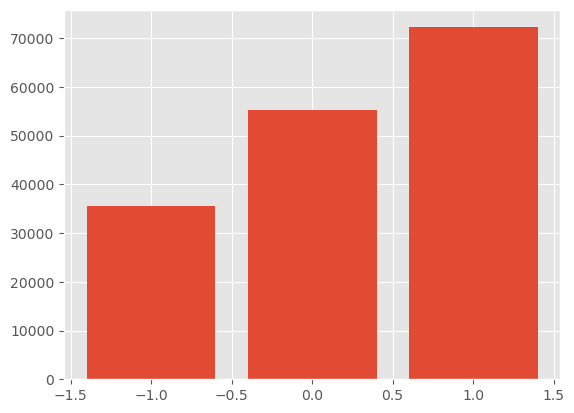

In [22]:
plt.bar(Twitter["labels"].value_counts().index , Twitter["labels"].value_counts().values)


<BarContainer object of 3 artists>

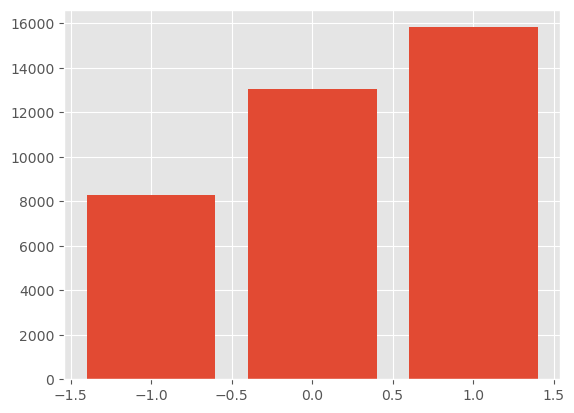

In [23]:
plt.bar(Reddint["labels"].value_counts().index , Reddint["labels"].value_counts().values)


In [24]:
# To concatenat Reddit and Twitter reviews
Merged_data = pd.concat([Twitter, Reddint], ignore_index=True)



In [25]:
Merged_data

,messages,labels
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0
...,...,...
200113,jesus,0.0
200114,kya bhai pure saal chutiya banaya modi aur jab...,1.0
200115,downvote karna tha par upvote hogaya,0.0
200116,haha nice,1.0


In [26]:
Merged_data.isnull().sum()

messages    0
labels      0
dtype: int64

In [27]:
def replace_url(text):
    return re.sub(r'https?:\/\/\S*|www\.\S+', 'URL', text)

def remove_html(text):
    return re.sub(r'<.*?>', '', text)

def replace_mentions(text):
    return re.sub(r'@\S*', 'user', text, flags=re.IGNORECASE)

def replace_num(text):
    return re.sub(r'^[+-]*?\d{1,3}[- ]*?\d{1,10}|\d{10}', 'NUMBER', text)

def replace_heart(text):
    return re.sub(r'<3', 'HEART', text)

def remove_alphanumeric(text):
    return re.sub(r'\w*\d+\w*', '', text)

def remove_stopwords(text):
    stop_words = set(stopwords.words("english")) 
    return ' '.join([word for word in text.split() if word not in stop_words])

def remove_punctuations(text):
    return ''.join([char for char in text if char not in string.punctuation])

def lemmatization(text):
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])

In [28]:
def clean_text(text):
    text = str(text).lower()  # Convert text to lowercase
    text = replace_url(text)  # Replace URLs
    text = remove_html(text)  # Remove HTML tags
    text = replace_mentions(text)  # Replace mentions (@username) with "user"
    text = replace_num(text)  # Replace numbers with "NUMBER"
    text = replace_heart(text)  # Replace "<3" with "HEART"
    text = remove_alphanumeric(text)  # Remove alphanumeric words (e.g., "XYZ123ABC")
    text = remove_stopwords(text)  # Remove stopwords
    text = remove_punctuations(text)  # Remove punctuation
    # text = stemming(text)  # Uncomment if stemming is needed
    text = lemmatization(text)  # Apply lemmatization
    return text  # Return the cleaned text


In [29]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words[:10])

     

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [30]:
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words[:10])
nltk.data.path.append('/root/nltk_data')
nltk.download('all')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading package chat80 to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package city_database to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package city_database is already up-to-date!
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package comparative_sentences to
[nltk_data]    |     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]    |   Package comparative_sentences is already up-to-
[nltk_data]    |       date!
[nltk_data]    | Downloadin

True

In [31]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatization(text):
    lm = WordNetLemmatizer()
    text = ' '.join([lm.lemmatize(word, pos='v') for word in text.split()])
    return text

Merged_data['messages1'] = Merged_data['messages'].apply(clean_text)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [32]:
Merged_data['messages1']


0         modi promise “minimum government maximum gover...
1                    talk nonsense continue drama vote modi
2         say vote modi welcome bjp tell rahul main camp...
3         ask supporters prefix chowkidar name modi grea...
4         answer among powerful world leader today trump...
                                ...                        
200113                                                jesus
200114    kya bhai pure saal chutiya banaya modi aur jab...
200115                 downvote karna tha par upvote hogaya
200116                                            haha nice
200117                              facebook work bjp’ cell
Name: messages1, Length: 200118, dtype: object

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Sentiment Analysis
</h1>

In [33]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Teto\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [34]:
sid = SentimentIntensityAnalyzer()

def get_sentiment_scores(text):
    scores = sid.polarity_scores(text)
    compound_score = scores['compound']
    return compound_score

Merged_data['sentiment_score'] = Merged_data['messages1'].apply(get_sentiment_scores)

In [35]:
Merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200118 entries, 0 to 200117
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   messages         200118 non-null  object 
 1   labels           200118 non-null  float64
 2   messages1        200118 non-null  object 
 3   sentiment_score  200118 non-null  float64
dtypes: float64(2), object(2)
memory usage: 6.1+ MB


In [36]:
Merged_data.drop('messages', axis=1, inplace=True)


In [37]:
Merged_data.head()

,labels,messages1,sentiment_score
0,-1.0,modi promise “minimum government maximum gover...,0.4939
1,0.0,talk nonsense continue drama vote modi,-0.4019
2,1.0,say vote modi welcome bjp tell rahul main camp...,0.7096
3,1.0,ask supporters prefix chowkidar name modi grea...,0.4939
4,1.0,answer among powerful world leader today trump...,0.4215


<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Data Visualisation</h1>

<Axes: xlabel='labels'>

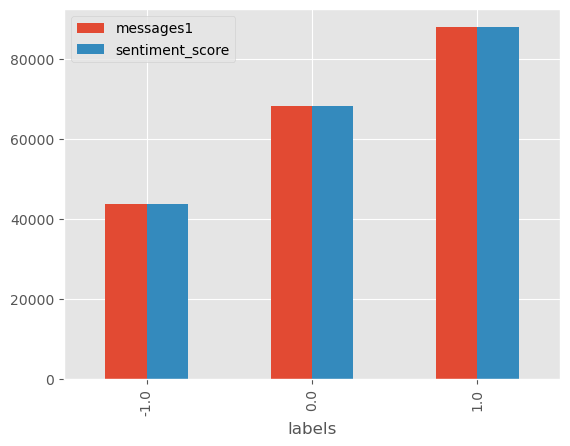

In [38]:
Merged_data.groupby('labels').count().plot(kind='bar')


In [39]:
Merged_data['label'] = Merged_data['labels'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})


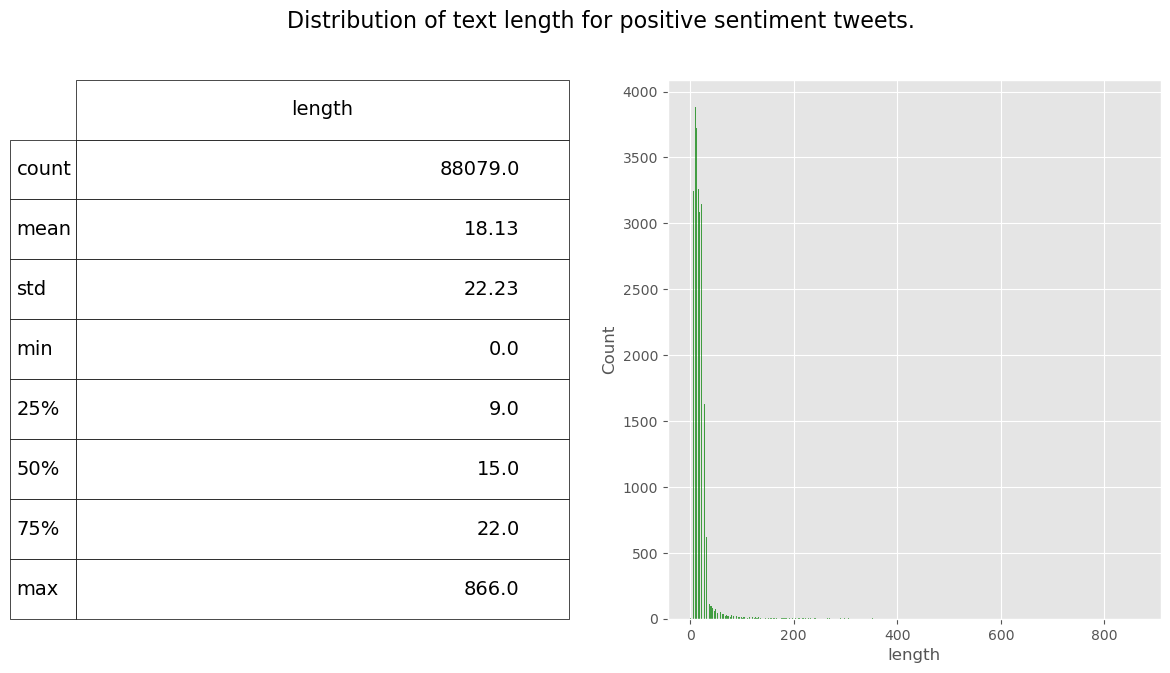

In [ ]:
fig = plt.figure(figsize=(14,7))
Merged_data['length'] = Merged_data.messages1.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(Merged_data[Merged_data['label']=='Positive']['length'], ax=ax1,color='green')
describe = Merged_data.length[Merged_data.label=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()


Text(0, 0.5, 'Frequency')

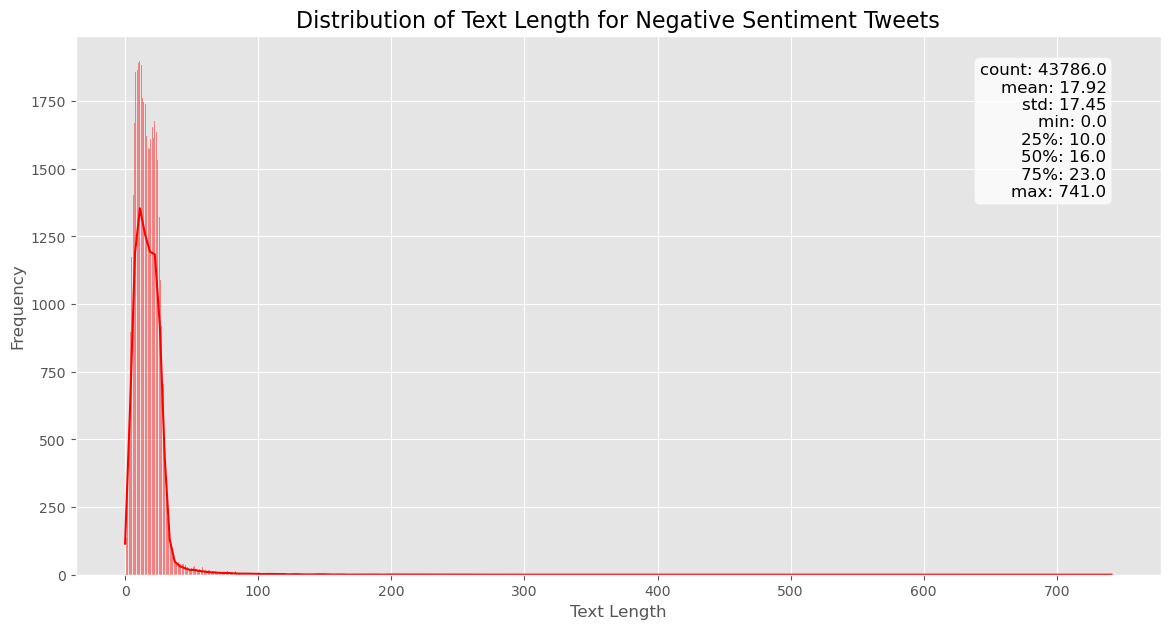

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

Merged_data['length'] = Merged_data.messages1.str.split().apply(len)
sns.histplot(Merged_data[Merged_data['label'] == 'Negative']['length'], ax=ax, color='red', kde=True)

describe = Merged_data.length[Merged_data.label == 'Negative'].describe().to_frame().round(2)
stats_text = "\n".join([f"{index}: {value[0]}" for index, value in describe.iterrows()])
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

ax.text(
    0.95, 0.95, stats_text,
    transform=ax.transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props
)

ax.set_title('Distribution of Text Length for Negative Sentiment Tweets', fontsize=16)
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')


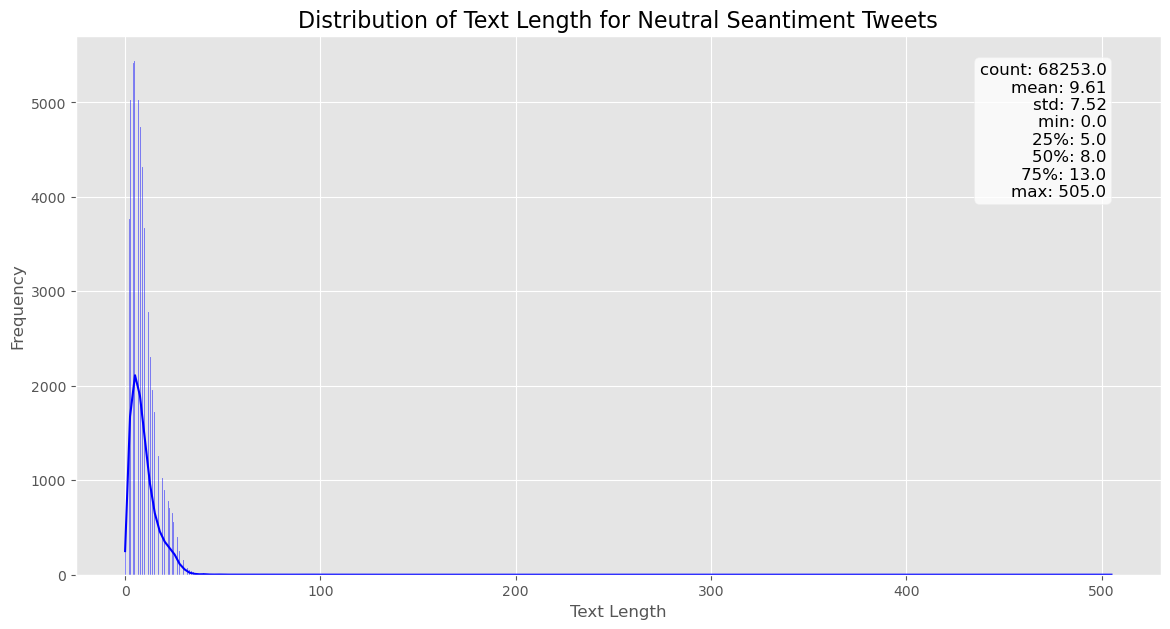

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(14, 7))

Merged_data['length'] = Merged_data.messages1.str.split().apply(len)
sns.histplot(Merged_data[Merged_data['label'] == 'Neutral']['length'], ax=ax, color='blue', kde=True)

describe = Merged_data.length[Merged_data.label == 'Neutral'].describe().to_frame().round(2)
stats_text = "\n".join([f"{index}: {value[0]}" for index, value in describe.iterrows()])
props = dict(boxstyle='round', facecolor='white', alpha=0.8)

ax.text(
    0.95, 0.95, stats_text,
    transform=ax.transAxes,
    fontsize=12, verticalalignment='top', horizontalalignment='right', bbox=props
)

ax.set_title('Distribution of Text Length for Neutral Seantiment Tweets', fontsize=16)
ax.set_xlabel('Text Length')
ax.set_ylabel('Frequency')

plt.show()

In [43]:
Merged_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200118 entries, 0 to 200117
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   labels           200118 non-null  float64
 1   messages1        200118 non-null  object 
 2   sentiment_score  200118 non-null  float64
 3   label            200118 non-null  object 
 4   length           200118 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 7.6+ MB


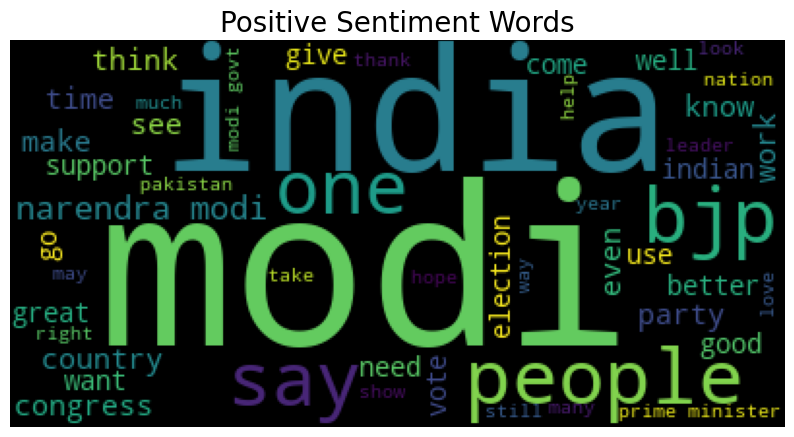

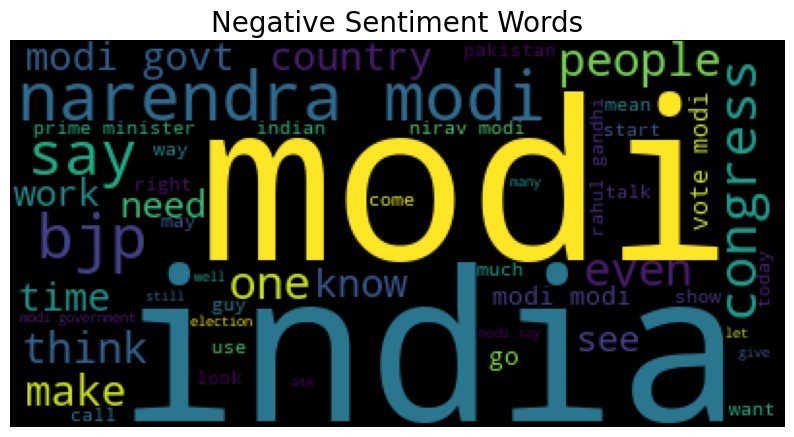

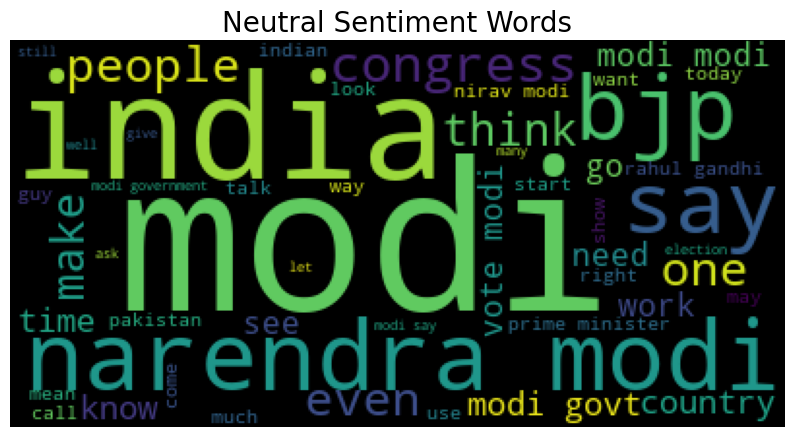

In [44]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
def wordcount_gen(df, category, sentiment_column='sentiment_score'):
              """
              Generating Word Cloud

              Inputs:
                - df: DataFrame containing the data
                - category: Positive/Negative/Neutral
                - sentiment_column (optional): Name of the column containing sentiment score (default: 'sentiment_score')
              """

              # Filter data based on sentiment
              filtered_data = df[df[sentiment_column] > 0.5] if category == 'Positive' else df[df[sentiment_column] <= 0.5]

              # Combine all messages from the filtered data
              combined_tweets = " ".join(filtered_data['messages1'])

              # Initialize wordcloud object
              wc = WordCloud(background_color='black',
                              max_words=50,
                              stopwords=STOPWORDS)

              # Generate and plot wordcloud
              plt.figure(figsize=(10, 10))
              plt.imshow(wc.generate(combined_tweets))
              plt.title('{} Sentiment Words'.format(category), fontsize=20)
              plt.axis('off')
              plt.show()
#Positive tweet words
wordcount_gen(Merged_data, 'Positive')

# Negative tweet words
wordcount_gen(Merged_data, 'Negative')

# Neutral tweet words (assuming sentiment_column < 0.5 is neutral)
wordcount_gen(Merged_data, 'Neutral')

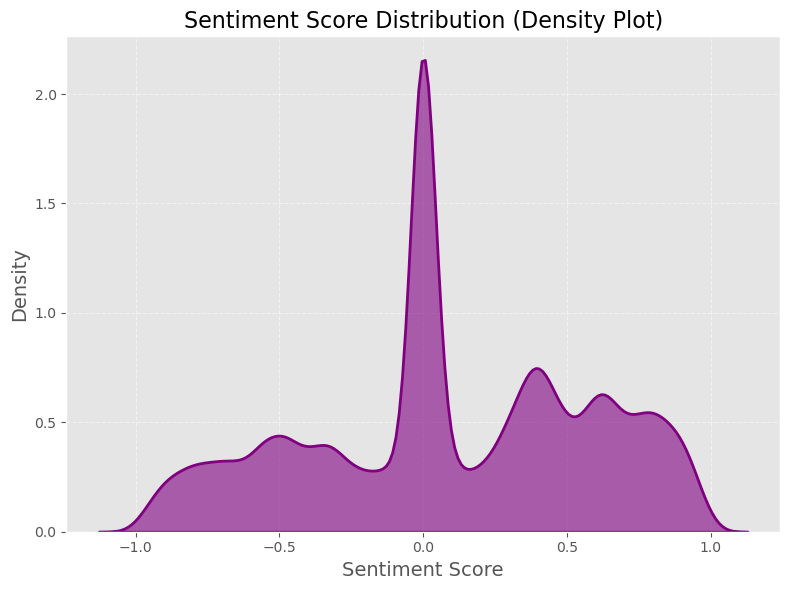

In [45]:
plt.figure(figsize=(8, 6))

sns.kdeplot(
    Merged_data['sentiment_score'],
    fill=True,
    color='purple',
    alpha=0.6,
    linewidth=2
)

plt.title('Sentiment Score Distribution (Density Plot)', fontsize=16)
plt.xlabel('Sentiment Score', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

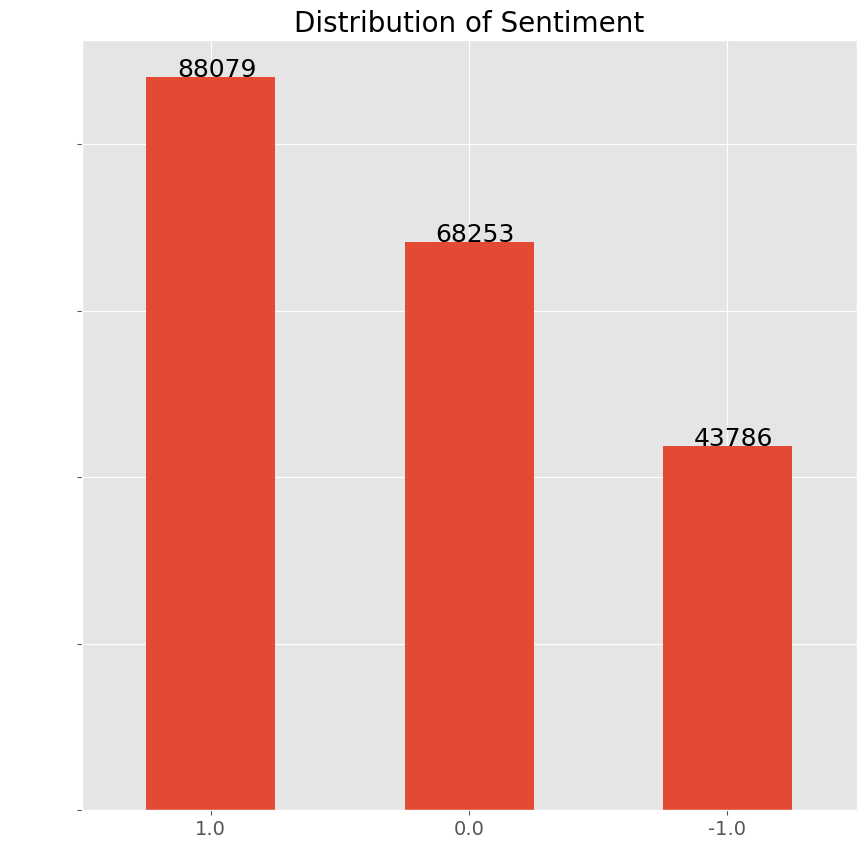

In [46]:
fig , ax = plt.subplots(figsize = (10,10))
ax = Merged_data['labels'].value_counts().plot(kind = 'bar')

plt.xticks(rotation = 0, size = 14)
plt.yticks(size = 14, color = 'white')
plt.title('Distribution of Sentiment', size = 20)

ax.annotate(text = Merged_data['labels'].value_counts().values[0], xy = (-0.13,88079), size = 18)
ax.annotate(text = Merged_data['labels'].value_counts().values[1], xy = (0.87,68253), size = 18)
ax.annotate(text = Merged_data['labels'].value_counts().values[2], xy = (1.87,43786), size = 18)

plt.show()

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Train & Test Split</h1>

In [ ]:
data = Merged_data.copy()

data['messages1'] = data['messages1'].fillna('')
data['label'] = data['label'].fillna('')

label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])

X = data['messages1']
y = data['label_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

<h1 style="font-family: 'Times New Roman'; letter-spacing: 0.08em;">Models & Evalution</h1>

              precision    recall  f1-score   support

    Negative       0.83      0.73      0.78      4379
     Neutral       0.79      0.92      0.85      6825
    Positive       0.88      0.82      0.85      8808

    accuracy                           0.84     20012
   macro avg       0.84      0.83      0.83     20012
weighted avg       0.84      0.84      0.84     20012



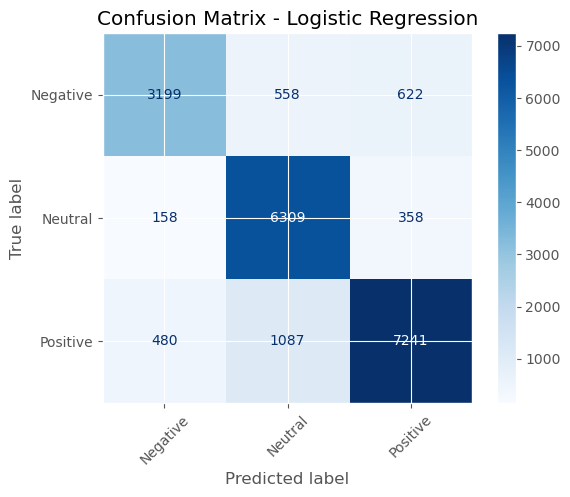

In [60]:

lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


              precision    recall  f1-score   support

    Negative       0.85      0.60      0.70      4379
     Neutral       0.71      0.93      0.81      6825
    Positive       0.86      0.78      0.81      8808

    accuracy                           0.79     20012
   macro avg       0.81      0.77      0.77     20012
weighted avg       0.81      0.79      0.79     20012



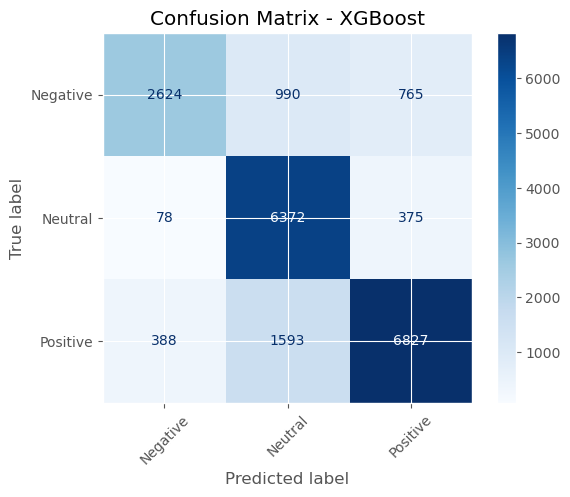

In [ ]:

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  
xgb.fit(X_train_tfidf, y_train)
y_pred_xgb = xgb.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=label_encoder.classes_)
disp_xgb.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - XGBoost")
plt.show()


              precision    recall  f1-score   support

    Negative       0.84      0.62      0.71      4379
     Neutral       0.78      0.89      0.83      6825
    Positive       0.82      0.83      0.82      8808

    accuracy                           0.81     20012
   macro avg       0.81      0.78      0.79     20012
weighted avg       0.81      0.81      0.80     20012



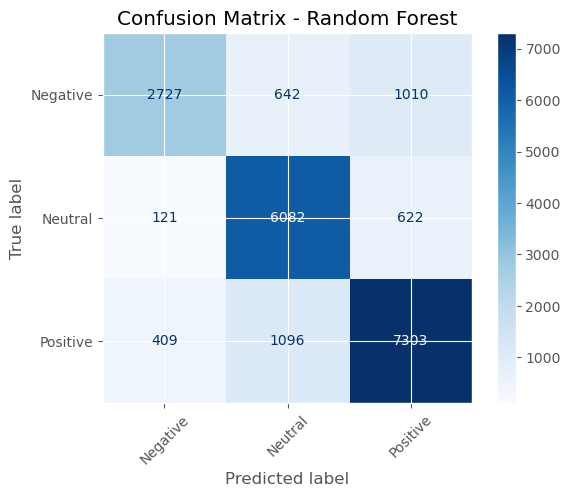

In [63]:

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

y_pred_rf = rf.predict(X_test_tfidf)

print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_encoder.classes_)
disp_rf.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [ ]:
def predict_using_model(text, model):
    text_cleaned = clean_text(text)             
    text_lemmatized = lemmatization(text_cleaned)  
    text_vectorized = tfidf_vectorizer.transform([text_lemmatized])  

    prediction = model.predict(text_vectorized)[0]
    label = label_encoder.inverse_transform([prediction])[0]  
    print(f"Input Text: {text}")
    print(f"Predicted Sentiment: {label}")


In [72]:
print("Logistic Regression: ")
predict_using_model("I LOVE you", lr)
predict_using_model("I Hate you", lr)
predict_using_model("It is a chair", lr)

print("-" * 100)

print("Random Forest: ")
predict_using_model("I LOVE you", rf)
predict_using_model("I Hate you", rf)
predict_using_model("It is a chair", rf)
print("-" * 100)

print("XGBoost: ")
predict_using_model("I LOVE you", xgb)
predict_using_model("I Hate you", xgb)
predict_using_model("It is a chair", xgb)

Logistic Regression: 
Input Text: I LOVE you
Predicted Sentiment: Positive
Input Text: I Hate you
Predicted Sentiment: Negative
Input Text: It is a chair
Predicted Sentiment: Neutral
----------------------------------------------------------------------------------------------------
Random Forest: 
Input Text: I LOVE you
Predicted Sentiment: Positive
Input Text: I Hate you
Predicted Sentiment: Negative
Input Text: It is a chair
Predicted Sentiment: Neutral
----------------------------------------------------------------------------------------------------
XGBoost: 
Input Text: I LOVE you
Predicted Sentiment: Positive
Input Text: I Hate you
Predicted Sentiment: Negative
Input Text: It is a chair
Predicted Sentiment: Neutral
